In [2]:
pre_names = """
dram-read-transactions
dram-write-transactions
gpc_cycles
l1hitreads
l1hitwrites
l1readaccess
l1writeaccess
l2-read-hits
l2-read-transactions
l2-write-hits
l2-write-transactions
occupancy
warp-inst
""".split()

post_names = """
dram-reads
dram-writes
gpc-cycles
l1-read-hits
l1-write-hits
l1-reads
l1-writes
l2-read-hits
l2-reads
l2-write-hits
l2-writes
occupancy
warp-insts
""".split()

mapping = dict(zip(pre_names, post_names))

In [3]:
import os
import glob
from typing import Union
import pandas as pd
import numpy as np

# Function to read csv files in folder
def read_csv(csv_path: str, csv_pattern: str, get_before = "", get_after = "") -> dict[str, pd.DataFrame]:
    dfs = {}
    for file in glob.glob(os.path.join(csv_path, csv_pattern)):
        
        # Remove file extension and check if the name is in the list
        pre_name = os.path.basename(file).split(".")[0]
        if pre_name in pre_names:
            
            # Read the CSV file into dataframe
            df = pd.read_csv(
                file, names=list("abcdefghij"), header=None
            )
            df = df.dropna(how="all").dropna(axis=1, how="all")
            
            # Convert to numeric
            df_tmp = df.apply(pd.to_numeric, errors="coerce").astype(np.float64)
            
            # Drop NaN rows, create final df
            nan_rows = df_tmp[df_tmp.isna().all(axis=1)].index
            nan_cols = df_tmp.columns[df_tmp.isna().all(axis=0)]
            df.drop(nan_rows, inplace=True)
            df_tmp = df_tmp.drop(nan_rows).drop(columns=nan_cols)
            df = pd.concat([df.iloc[:, 0], df_tmp.iloc[:, :2]], axis=1)
            
            # Clean first column
            if get_before != "":
                df.iloc[:, 0] = df.iloc[:, 0].str.split(get_before).str[0]
            if get_after != "":
                df.iloc[:, 0] = df.iloc[:, 0].str.split(get_after).str[-1]
            df.columns = ["Name", "Hardware", "Simulation"]
            
            # Store df in the dictionary
            dfs[mapping[pre_name]] = df
            
    return dfs

# Add measures to dataframe
def error(actual, predicted):
    return (actual - predicted) / np.where(
        predicted == 0, 1e-8, predicted
    )
def symmetric_error(actual, predicted):
    return np.where(
        np.abs(actual) + np.abs(predicted) == 0,
        np.where(
            actual - predicted == 0, 0, np.sign(actual - predicted)
        ),
        (actual - predicted) / (np.abs(actual) + np.abs(predicted))
    )
def add_measures(dfs: dict[str, pd.DataFrame], e = False, se = False, ae = False, sae = False) -> dict[str, pd.DataFrame]:
    for k in dfs.keys():
        hw = dfs[k]['Hardware'].to_numpy(np.float64)
        sm = dfs[k]['Simulation'].to_numpy(np.float64)
        if e:
            dfs[k]['E'] = error(hw, sm)
        if ae:
            dfs[k]['AE'] = np.abs(error(hw, sm))
        if se:
            dfs[k]['SE'] = symmetric_error(hw, sm)
        if sae:
            dfs[k]['SAE'] = np.abs(symmetric_error(hw, sm))
    return dfs

# Convert dict of dataframes to single MultiIndex df
def merge_dict(dfs: dict[str, pd.DataFrame]) -> pd.DataFrame:
    merged_dfs = pd.concat({k: v.set_index(v.columns[0]) for k, v in dfs.items()}, axis=1)
    # merged_dfs = pd.concat({k: v for k, v in dfs.items()}, axis=1)
    return merged_dfs

# Save to Excel
def write_xlsx_df(dfs: pd.DataFrame, xls_file: str):
    with pd.ExcelWriter(xls_file) as writer:
        if dfs.columns.nlevels == 1:
            dfs.to_excel(writer)
        else:
            labels = dfs.columns.get_level_values(0).unique()
            for label in labels:
                dfs.xs(label, level=0, axis=1).to_excel(writer, sheet_name=label)
def write_xlsx_dict(dfs: dict[str, pd.DataFrame], xls_file: str):
    with pd.ExcelWriter(xls_file) as writer:
        for key in dfs.keys():
            dfs[key].to_excel(writer, sheet_name=key)


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
CORE_CLOCK = 1650

def divide_results(p_deltas: dict, results_path: str, csv_pattern: str, get_before: str, get_after: str):
    index = 0
    main_dfs = {}
    for config_name in p_deltas.keys():
        for entry in p_deltas[config_name]:
            main_df = pd.DataFrame(columns=post_names)
            std_df = pd.DataFrame(columns=[name + "-std" for name in post_names])
            for vals in entry[2]:
                id = f"{str(index).zfill(4)}"
                id_path = os.path.join(results_path, id)
                if os.path.isdir(id_path):
                    dfs = read_csv(id_path, csv_pattern, get_before, get_after)
                    dfs = merge_dict(dfs)
                    dfs = dfs.swaplevel(0, 1, axis=1)
                    df = dfs['Simulation'].copy()
                    for metric in "l1-read", "l1-write", "l2-read", "l2-write":
                        df.loc[:, metric + "-hit-ratio"] = df[metric + "-hits"] / df[metric + "s"]

                    # Add runtime based on whether clock domains are changed
                    if config_name == "gpgpu_clock_domains" and 0 in entry[1]:
                        df.loc[:, "runtime"] = df["gpc-cycles"] / vals[0]
                    else:
                        df.loc[:, "runtime"] = df["gpc-cycles"] / CORE_CLOCK

                    # Append new row with sum of all
                    main_df = pd.concat([main_df, df.sum().to_frame().T], ignore_index=True)
                    std_df = pd.concat([std_df, df.std().to_frame().T.rename(columns=lambda col: f'{col}-std')], ignore_index=True)
                else:
                    # Append empty row for config with no results
                    main_df = pd.concat([main_df, pd.DataFrame([[np.nan] * main_df.shape[1]], columns=main_df.columns)], ignore_index=True)
                    std_df = pd.concat([std_df, pd.DataFrame([[np.nan] * std_df.shape[1]], columns=std_df.columns)], ignore_index=True)
                    
                index += 1
            
            # Add column(s) for varying parameter(s)
            aux_df = pd.DataFrame(entry[2], columns=entry[1])
            merged_df = pd.concat([aux_df, main_df, std_df], axis=1)
            cleaned_config_name = config_name.replace(":", "-")
            
            output_name = f"{cleaned_config_name}-{entry[0]}-" + "_".join([str(j) for j in entry[1]])
            main_dfs[output_name] = merged_df
            # # print(f"{cleaned_config_name}-{entry[0]}-" + "_".join([str(j) for j in entry[1]]))
            # write_xlsx_df(main_df, os.path.join(results_path, output_file + ".xlsx"))
    
    return main_dfs


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, EngFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'

def plot_equal(
    data, bounds,
    xlabel: str, ylabel: str, fignme: str,
    is_loglog = True, is_engformatter = False
):
    if is_loglog:
        plt.loglog(data[:, 0], data[:, 1], "x")
    else:
        plt.plot(data[:, 0], data[:, 1], "x")
    plt.grid(which='both', ls='--', c=".9")
    plt.axis("square")
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(bounds[0], bounds[1])
    plt.plot(bounds, bounds, ls="--", c=".6")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    if is_engformatter:
        ax = plt.gca()
        ax.xaxis.set_major_formatter(EngFormatter())
        ax.yaxis.set_major_formatter(EngFormatter())

    plt.title(
        "r = {:.4f}, MAE = {:.2f}%".format(
            np.corrcoef(data, rowvar=False)[0, 1],
            np.mean(np.abs(np.diff(data, axis=1)[:, 0]) / data[:, 0]) * 100
        ),
        loc="right"
    )
    plt.savefig(fignme, dpi=300, bbox_inches='tight')
    
def find_nearest_n(bounds: list[int], n=5):
    bounds = np.array(bounds)
    x = np.min(10 ** np.round(np.log10(bounds) - 1.5))
    y = bounds / x
    z = n * np.round(y / n + np.array([-0.5, 0.5])) * x
    return z

def plot_sequence(
    data, bounds,
    xlabel: str, ylabel: str,
    is_loglog = False, is_semilog = False, is_errorbar = False,
    is_engformatter = False, 
    ax = None
):
    if ax is None:
        ax = plt.gca()
    
    if is_loglog:
        ax.loglog(data[:, 0], data[:, 1], "-o", markerfacecolor='none')
    elif is_semilog:
        ax.semilogy(data[:, 0], data[:, 1], "-o", markerfacecolor='none')
    elif is_errorbar:
        ax.errorbar(data[:, 0], data[:, 1], data[:, 2], linestyle='-', marker='o', markerfacecolor='none', capsize=3)
    else:
        ax.plot(data[:, 0], data[:, 1], "-o", markerfacecolor='none')
    
    if is_engformatter:
        ax.xaxis.set_major_formatter(EngFormatter())
        ax.yaxis.set_major_formatter(EngFormatter())
        
    ax.grid(which='both', ls='--', c=".9")
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Test section

## Test 2

In [9]:
results_path = "util/plotting/correl-html/test2-cuDGT"
jsn_folder = "json"
csv_pattern = "*kernel.raw.csv"
xls_path = results_path
xls_file = "all.xlsx"

import json
cfg_path = "util/tuner/RTX2080_S"
p_dlt_file = "parsed_deltas_cuDGT_test2.json"

with open(os.path.join(cfg_path, p_dlt_file)) as f:
    p_deltas = json.load(f)

dfs = divide_results(p_deltas, results_path, csv_pattern, get_before=" ", get_after="-")
write_xlsx_dict(dfs, os.path.join(xls_path, xls_file))

/tmp/ipykernel_2847083/2637712902.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(bounds[0], bounds[1])


/tmp/ipykernel_2847083/4184046327.py:54: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(os.path.join(results_path, "log-" + key), dpi=300, bbox_inches='tight')


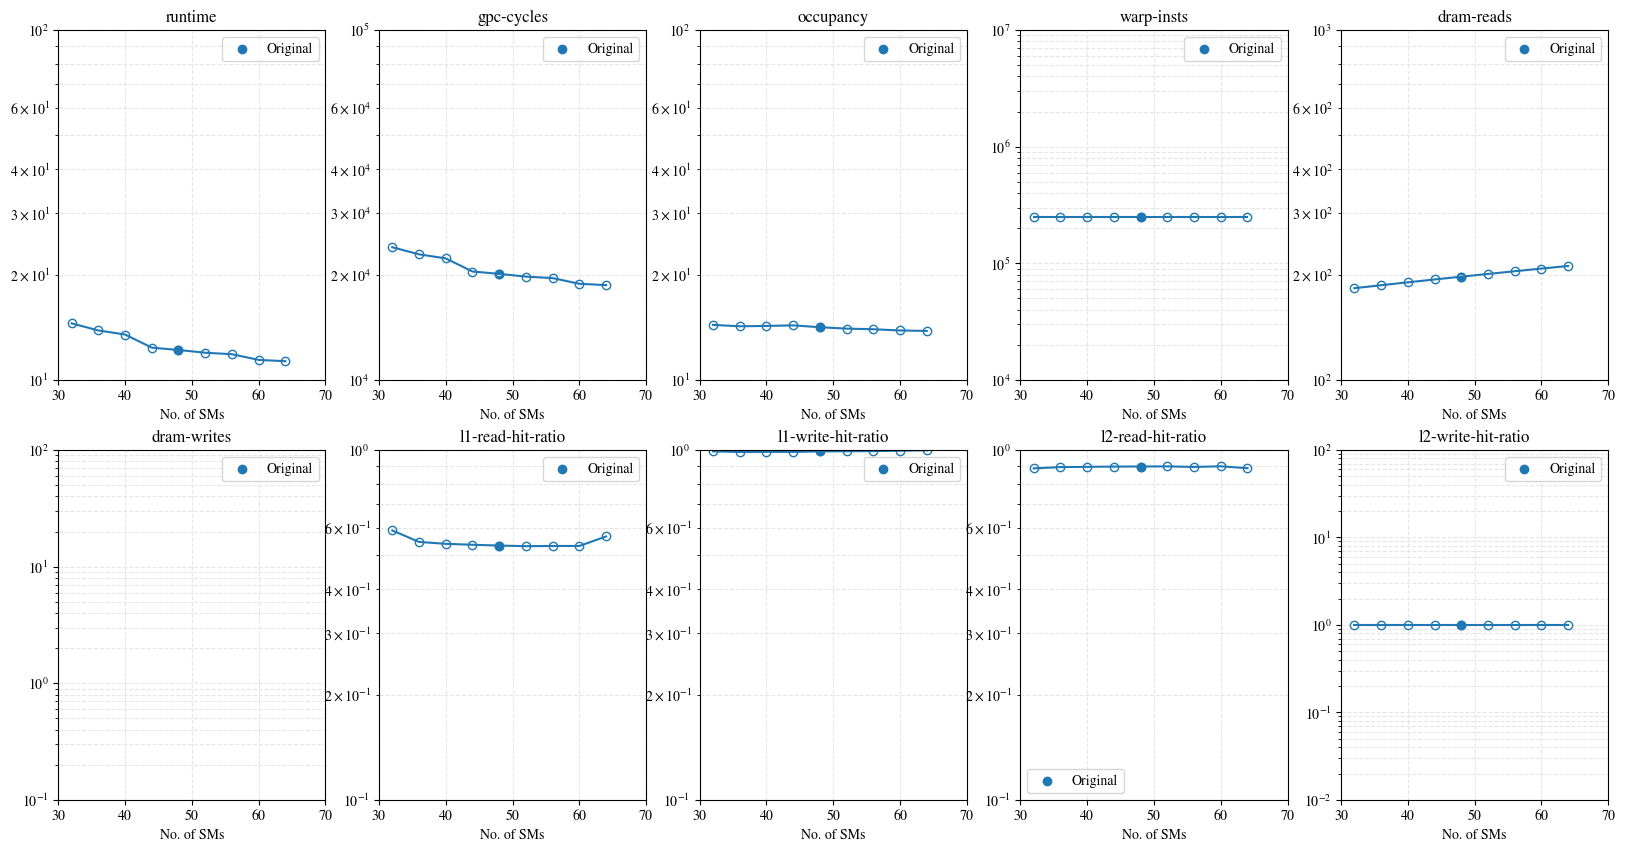

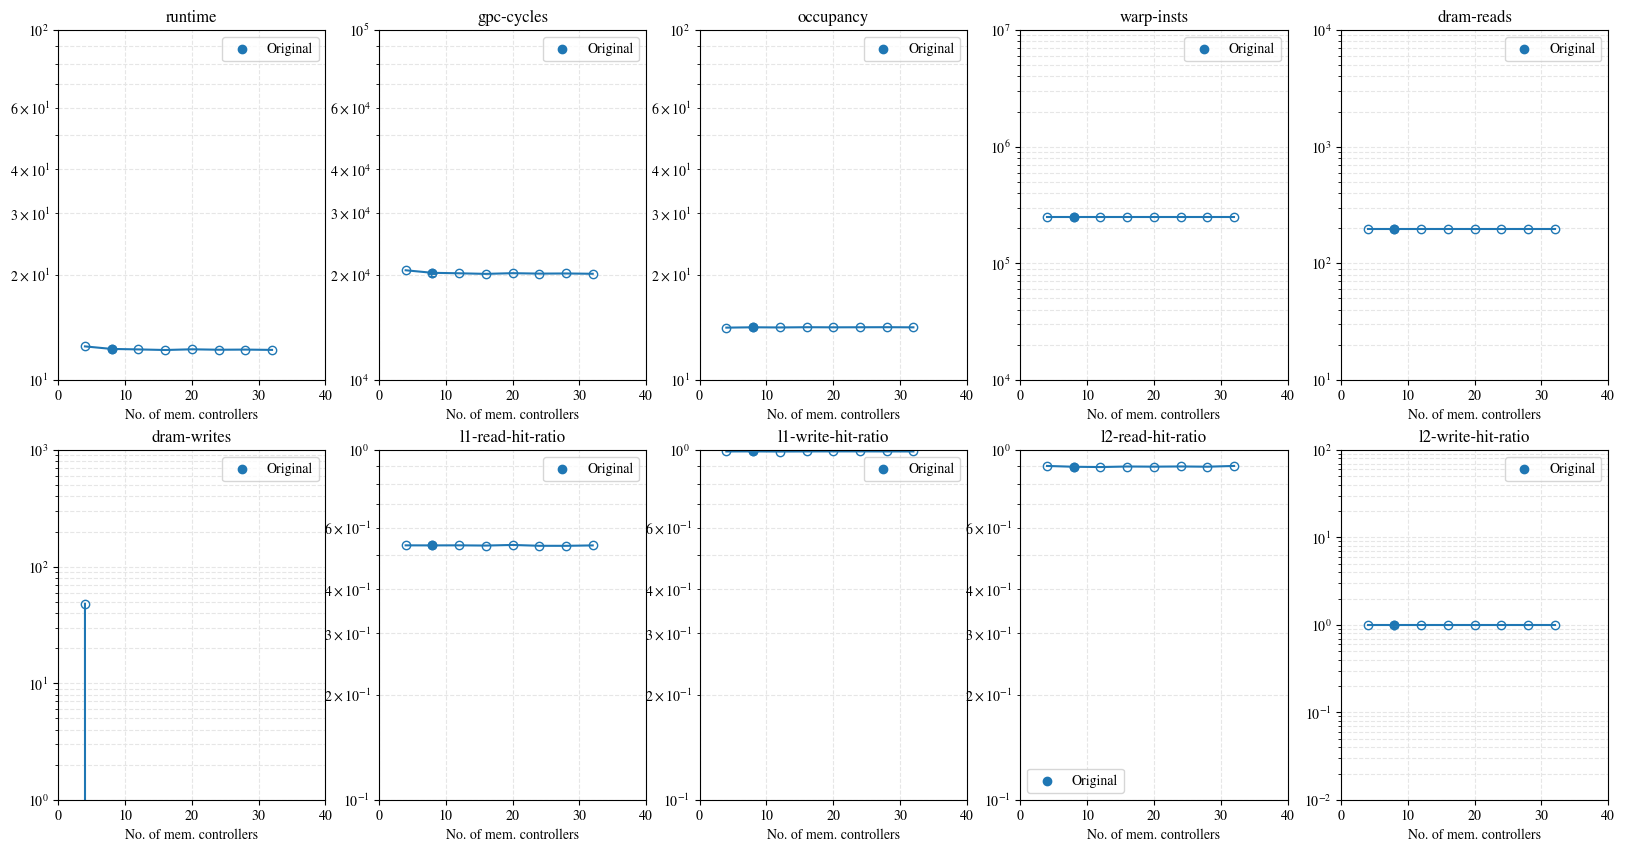

/tmp/ipykernel_2847083/2637712902.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(bounds[0], bounds[1])
/tmp/ipykernel_2847083/4184046327.py:54: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(os.path.join(results_path, "log-" + key), dpi=300, bbox_inches='tight')


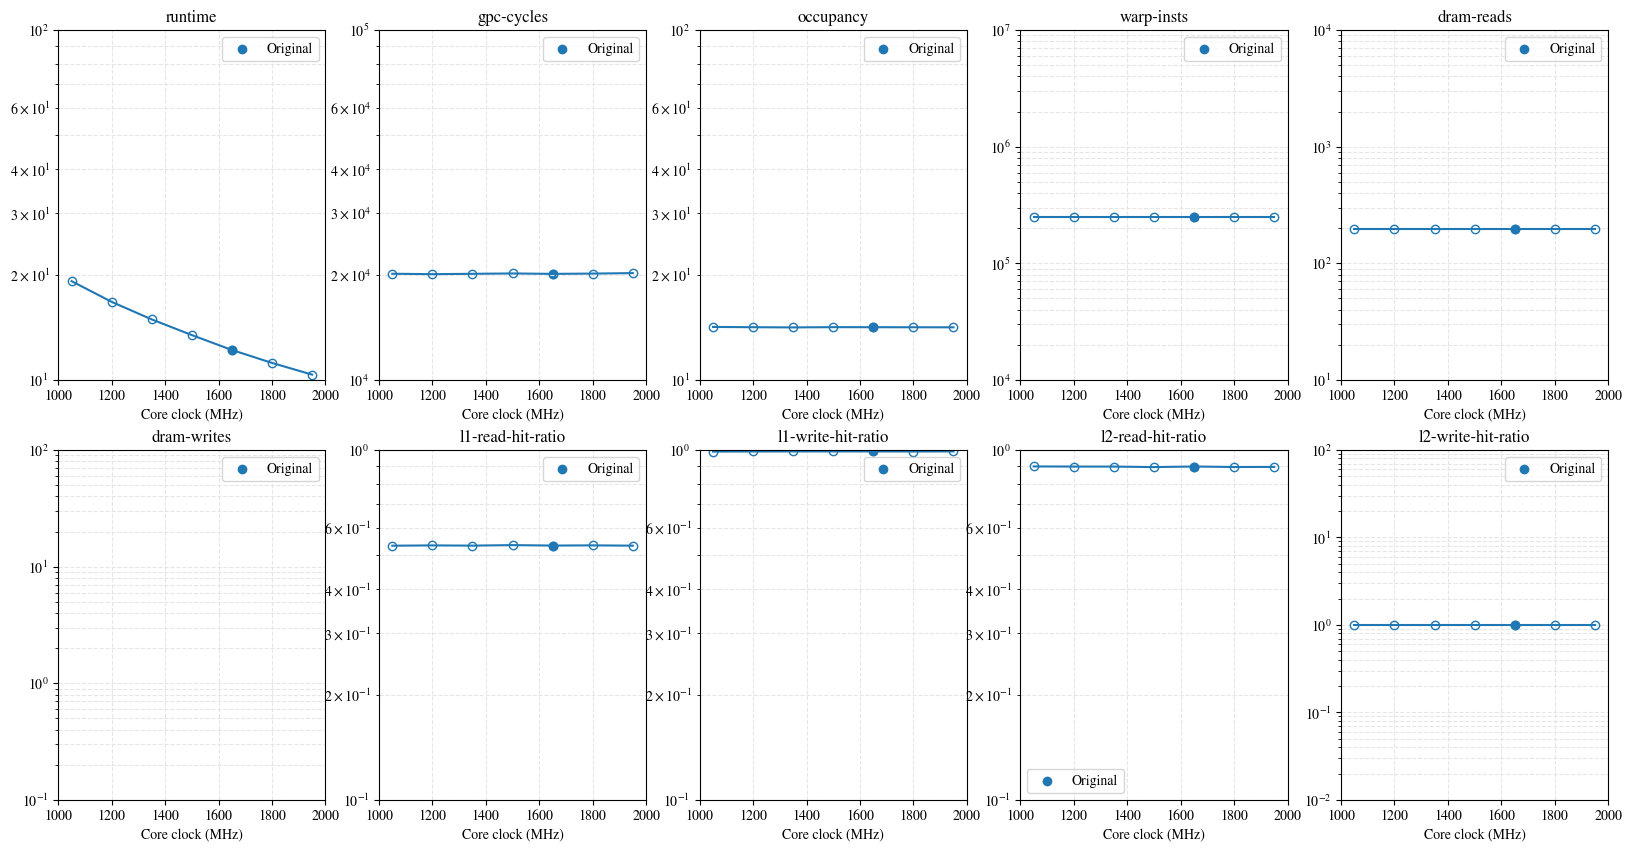

/tmp/ipykernel_2847083/2637712902.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(bounds[0], bounds[1])
/tmp/ipykernel_2847083/4184046327.py:54: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(os.path.join(results_path, "log-" + key), dpi=300, bbox_inches='tight')


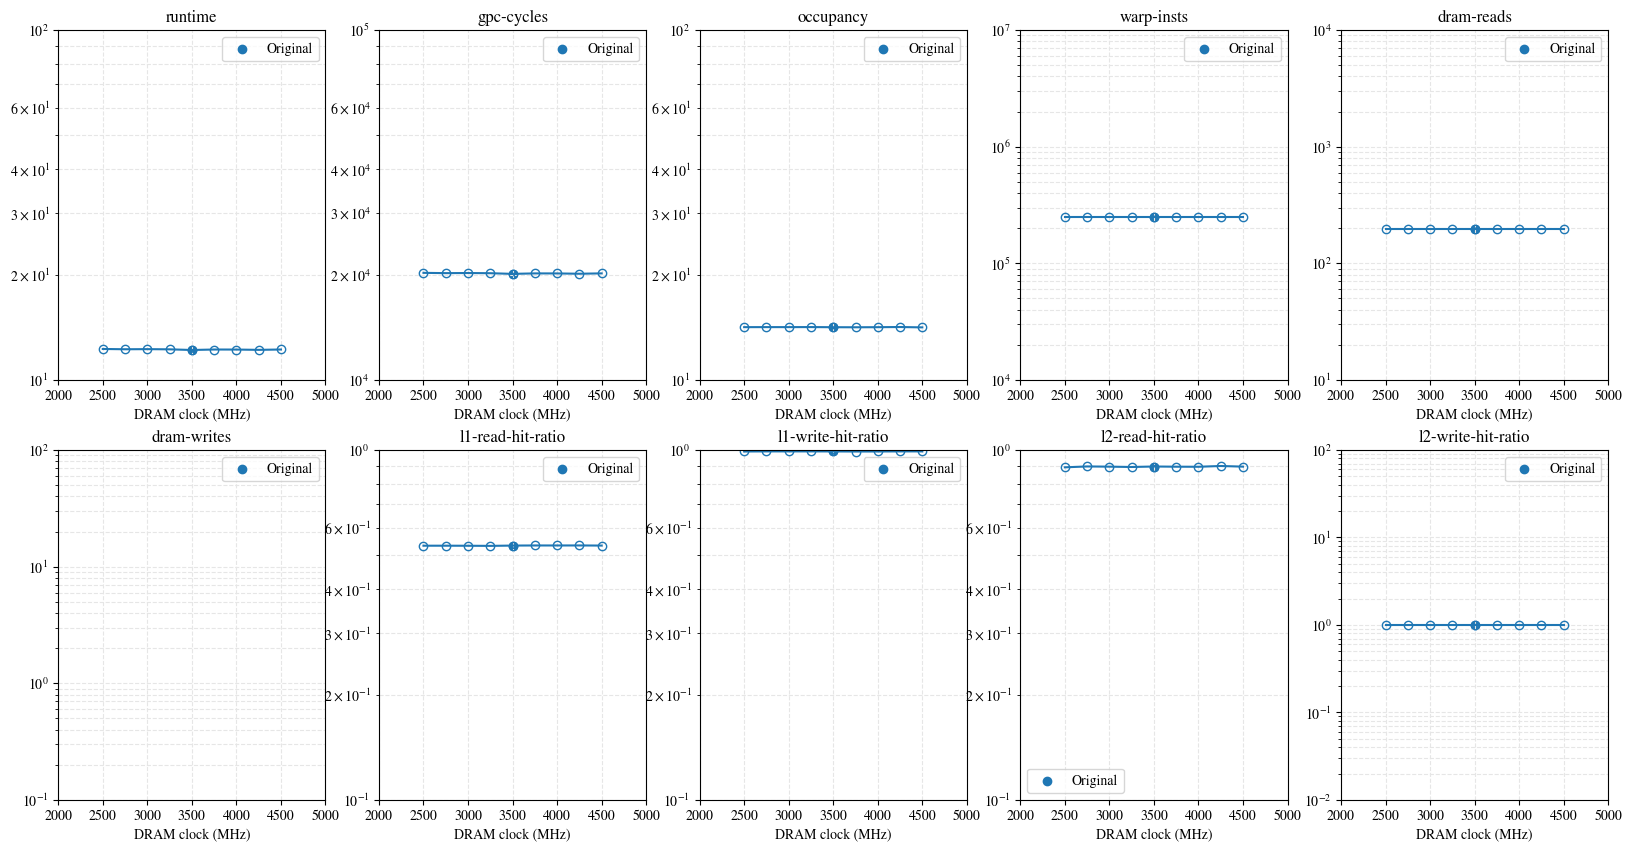

/tmp/ipykernel_2847083/2637712902.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(bounds[0], bounds[1])
/tmp/ipykernel_2847083/4184046327.py:54: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(os.path.join(results_path, "log-" + key), dpi=300, bbox_inches='tight')


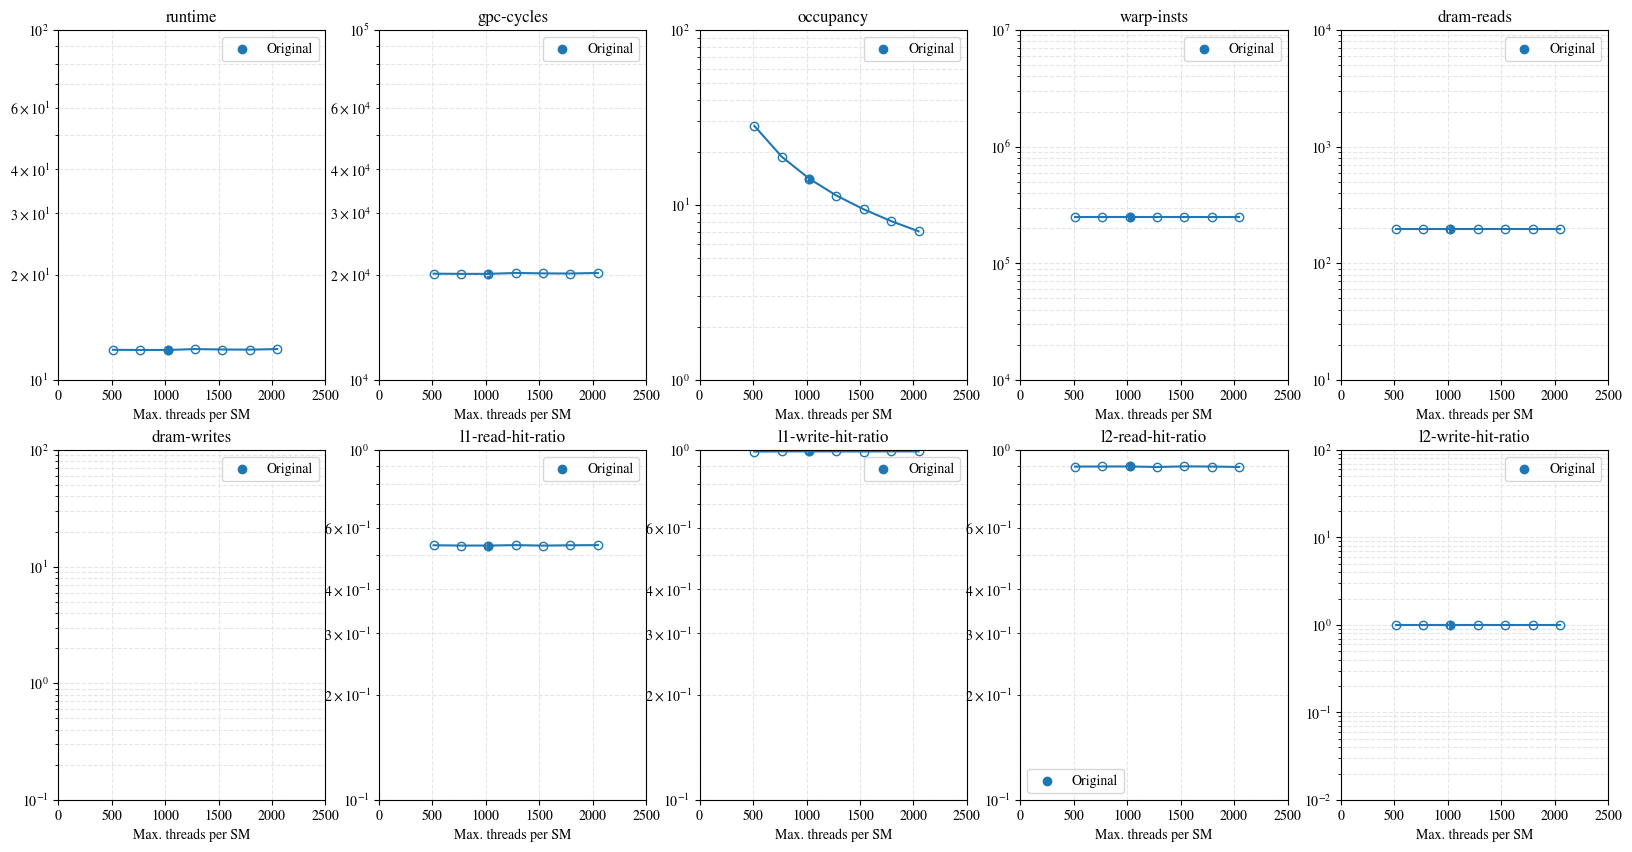

In [23]:
plot_data = {
    "gpgpu_n_clusters-0-0": [0, "No. of SMs", 48],
    "gpgpu_n_mem-0-0": [0, "No. of mem. controllers", 8],
    "gpgpu_clock_domains-0-0_1_2": [0, "Core clock (MHz)", 1650],
    "gpgpu_clock_domains-0-3": [0, "DRAM clock (MHz)", 3500],
    "gpgpu_shader_core_pipeline-0-0": [0, "Max. threads per SM", 1024],
    "gpgpu_cache-dl1-0-1_2_3": [],
    "gpgpu_shmem_size-0-0": [],
    "gpgpu_cache-dl2-0-1_2_3": [],
    "gpgpu_cache-il1-0-1_2_3": [],
    "gpgpu_tex_cache-l1-0-1_2_3": [],
    "gpgpu_const_cache-l1-0-1_2_3": [],
}

# Loop through data
plot_names = """
runtime
gpc-cycles
occupancy
warp-insts
dram-reads
dram-writes
l1-read-hit-ratio
l1-write-hit-ratio
l2-read-hit-ratio
l2-write-hit-ratio
""".split()
ncols = 5
nrows = int(np.round(len(plot_names)) / float(ncols) + 0.5)

for key in plot_data.keys():
    if len(plot_data[key]) > 0: # "cache" not in key and 
        plt.close('all')
        fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
        for index, metric in enumerate(plot_names):
            ax = axes[index // ncols, index % ncols]
            data = dfs[key].iloc[:, [plot_data[key][0]]].join(dfs[key][metric]).drop_duplicates().to_numpy() # dfs[key][[0, metric]].to_numpy() .join(dfs[key][metric + "-std"])
            
            xlabel = plot_data[key][1]
            ylabel = None
            bounds = find_nearest_n([data[0, 0], data[-1, 0]], 5)
            data[:, 1] /= 20

            plot_sequence(data, bounds, xlabel, ylabel, ax=ax)
            nearest_index = np.argmin(np.abs(data[:, 0] - plot_data[key][2]))
            ax.scatter(data[nearest_index, 0], data[nearest_index, 1], label='Original')
            ax.relim()
            ax.autoscale()
            ax.set_ylim(bottom=0)
            ax.legend()
            ax.set_title(metric)
        
        fig.set_size_inches(20, 10)
        plt.savefig(os.path.join(results_path, "zero-" + key), dpi=300, bbox_inches='tight')
        plt.show()

## Test 1

In [42]:
results_path = "util/plotting/correl-html/test1-cuDGT"
jsn_folder = "json"
csv_pattern = "*kernel.raw.csv"
xls_path = results_path
xls_file = "all.xlsx"

import json
cfg_path = "util/tuner/RTX2080_S"
p_dlt_file = "parsed_deltas.json"

with open(os.path.join(cfg_path, p_dlt_file)) as f:
    p_deltas = json.load(f)

dfs = divide_results(p_deltas, results_path, csv_pattern, get_before=" ", get_after="-")
write_xlsx_dict(dfs, os.path.join(xls_path, xls_file))

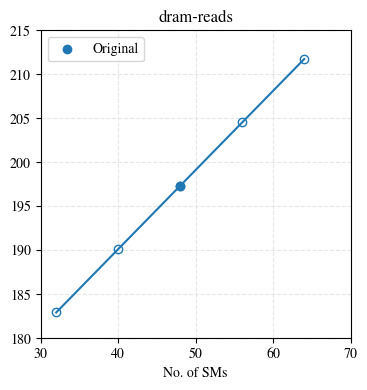

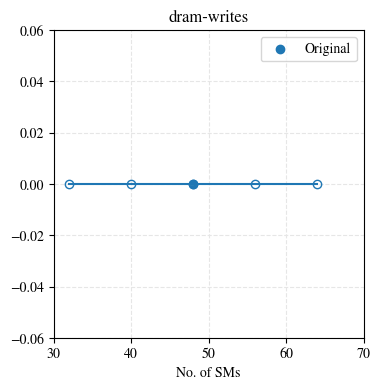

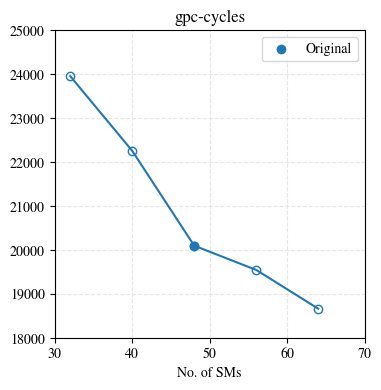

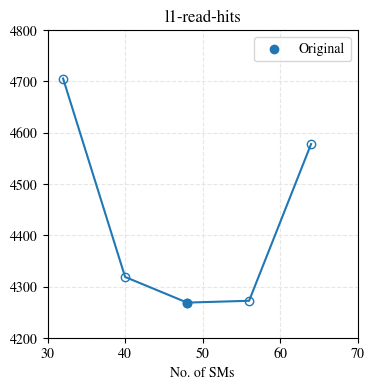

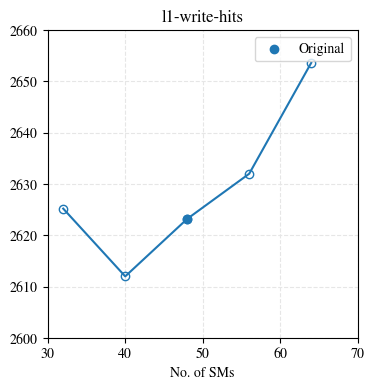

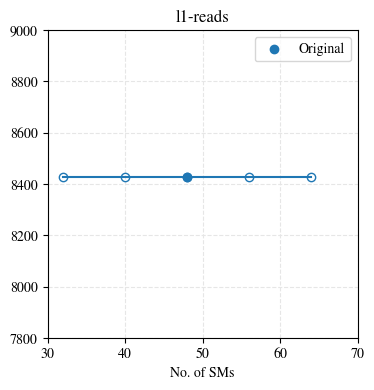

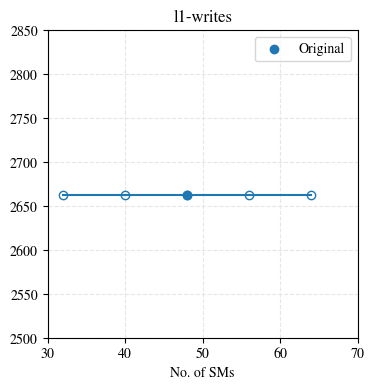

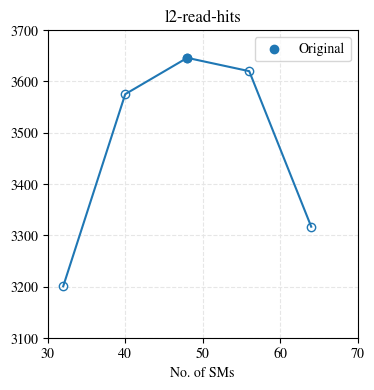

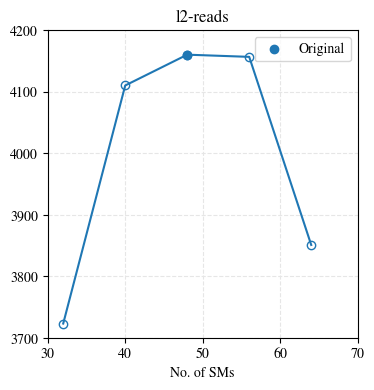

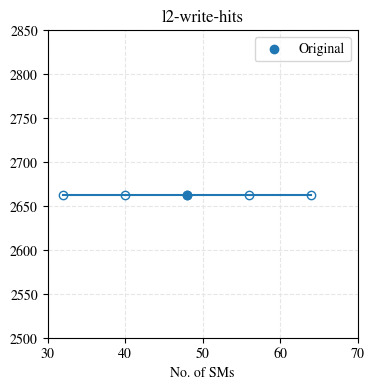

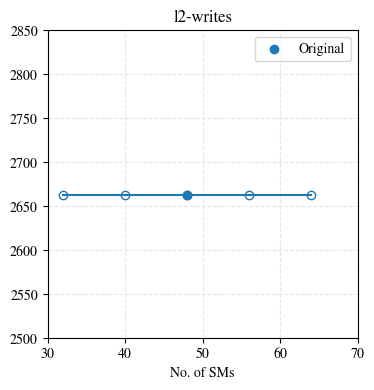

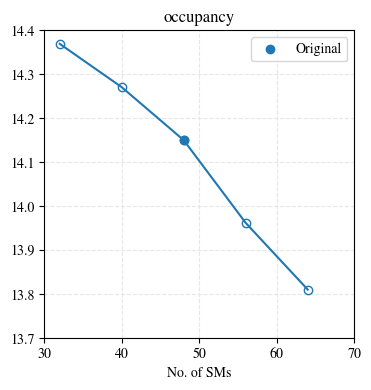

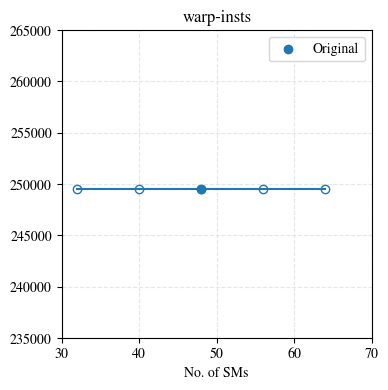

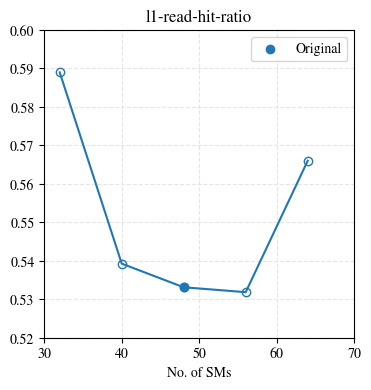

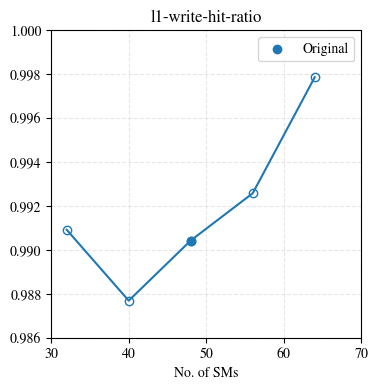

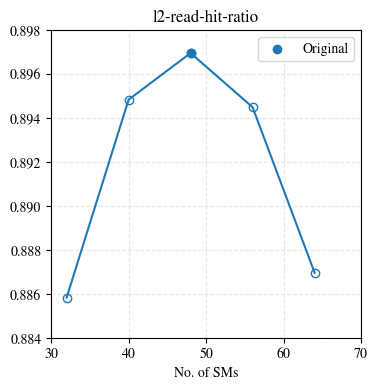

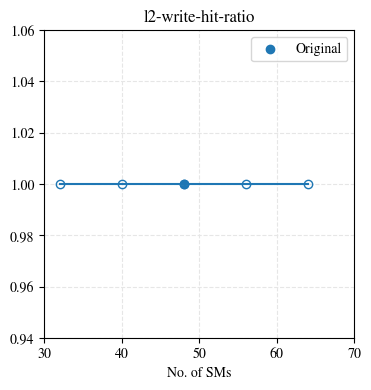

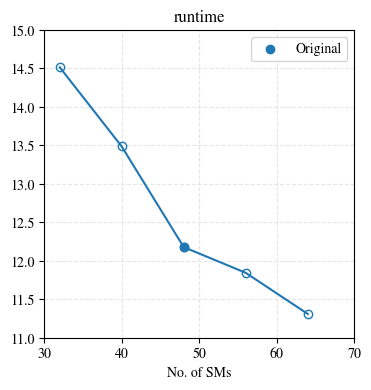

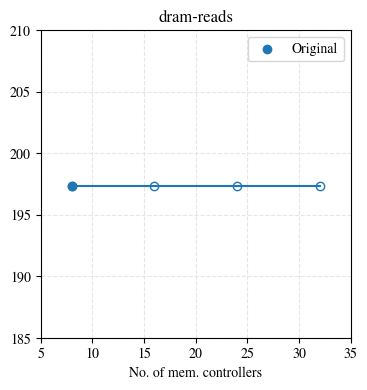

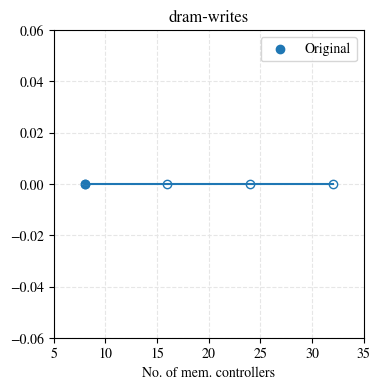

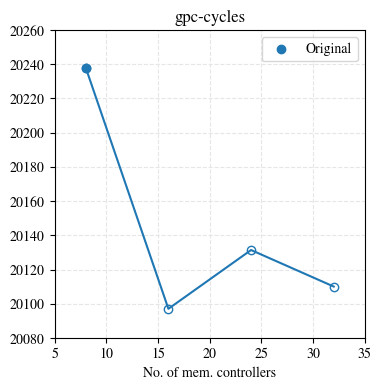

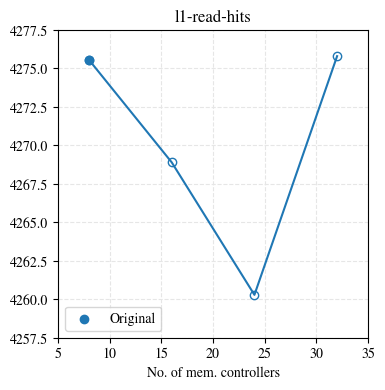

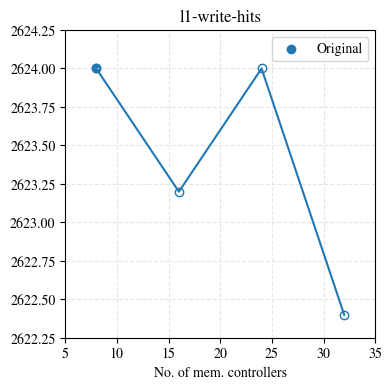

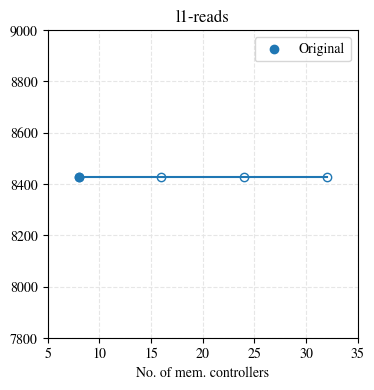

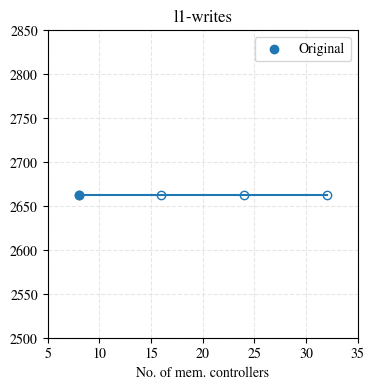

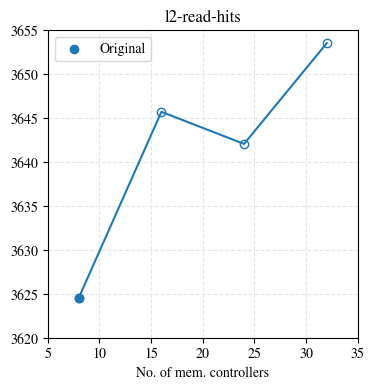

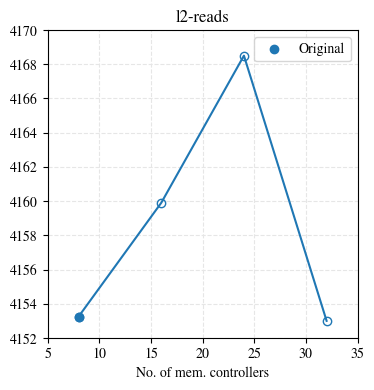

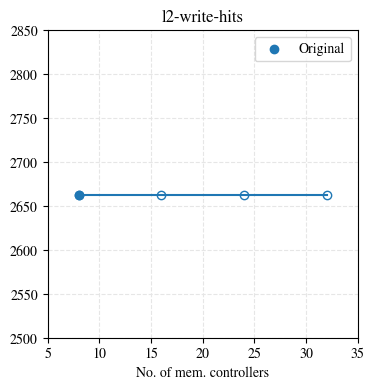

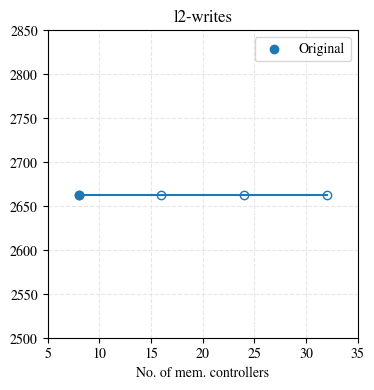

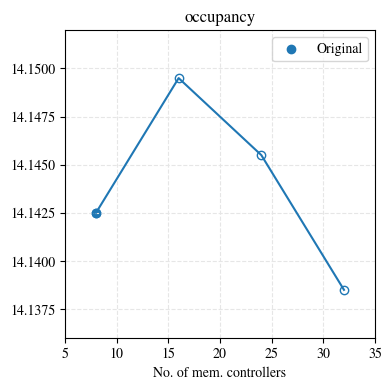

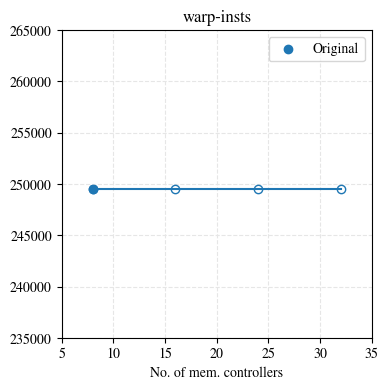

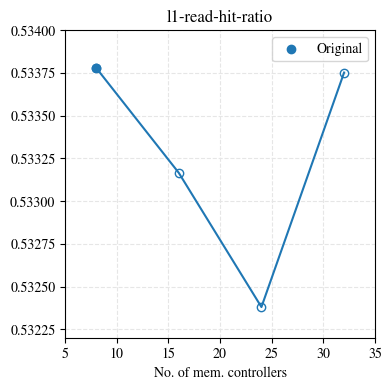

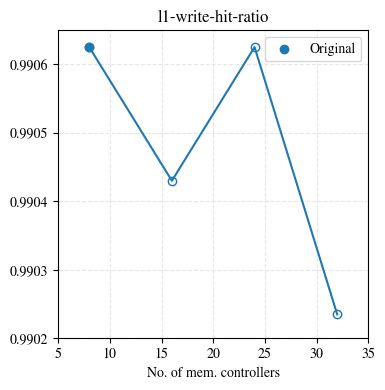

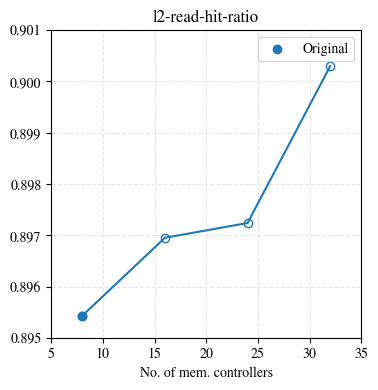

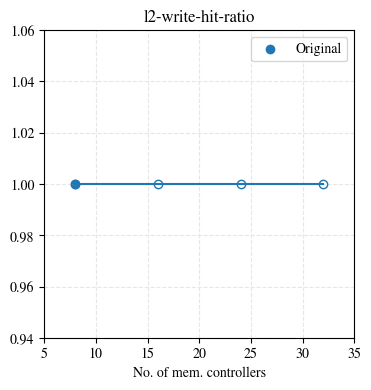

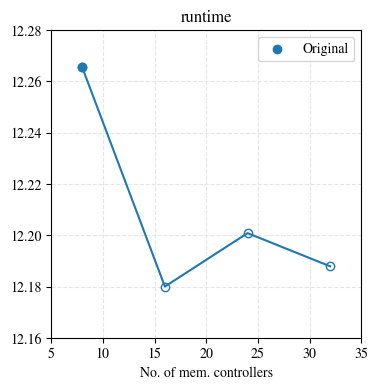

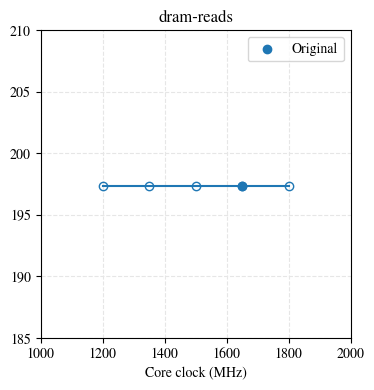

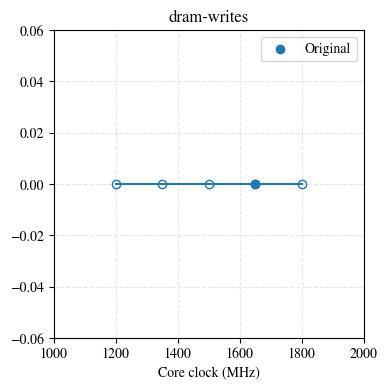

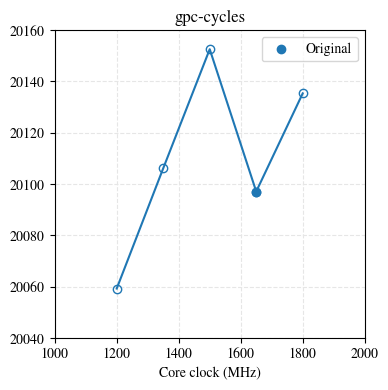

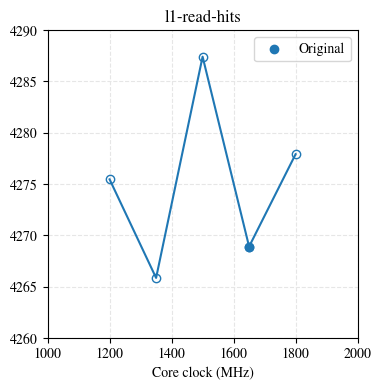

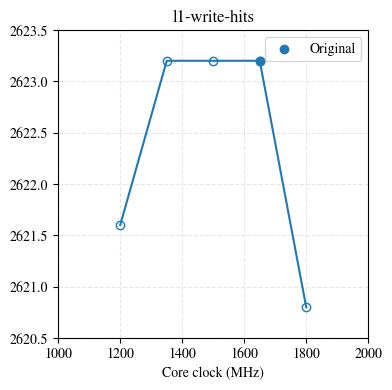

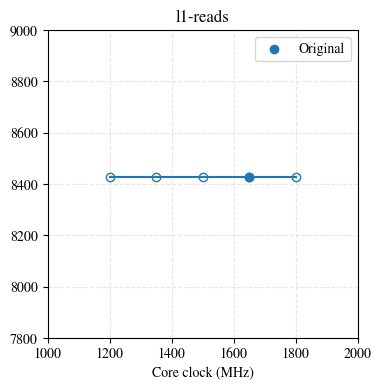

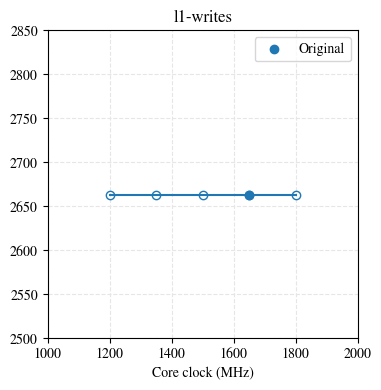

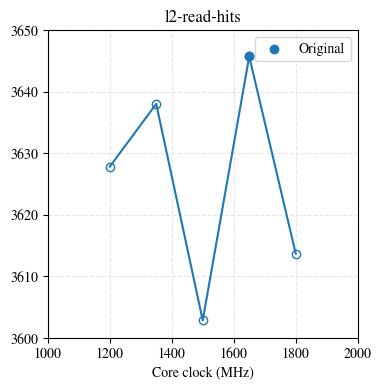

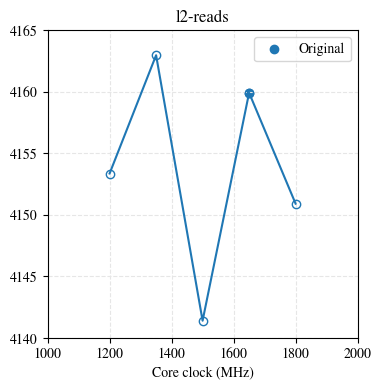

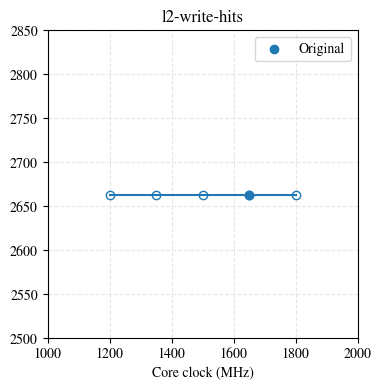

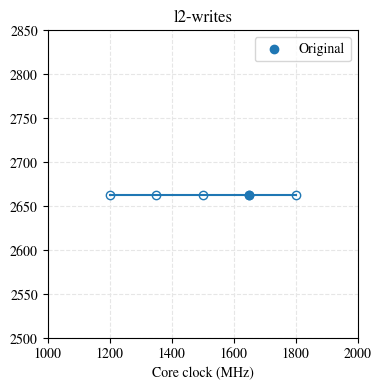

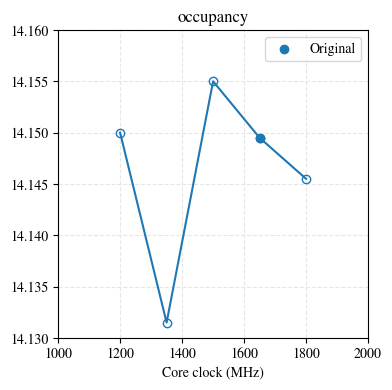

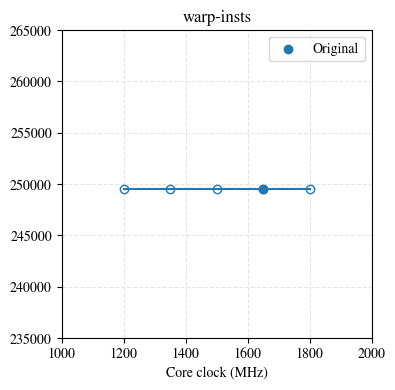

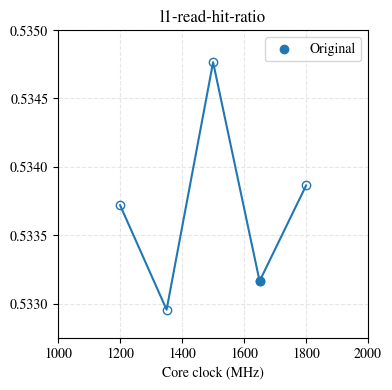

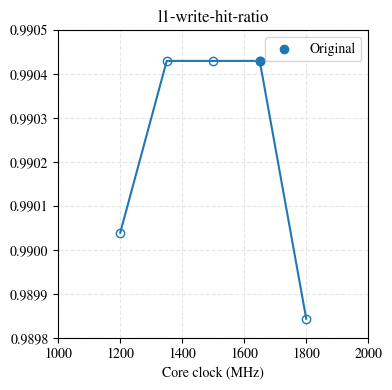

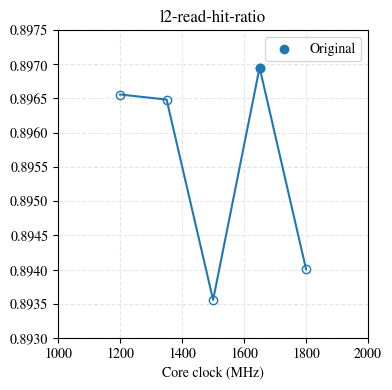

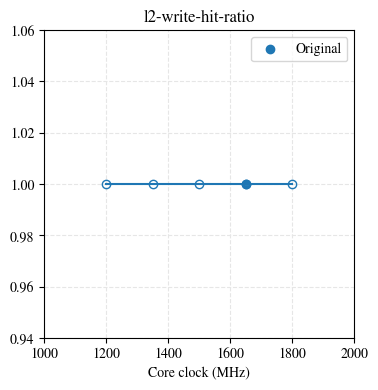

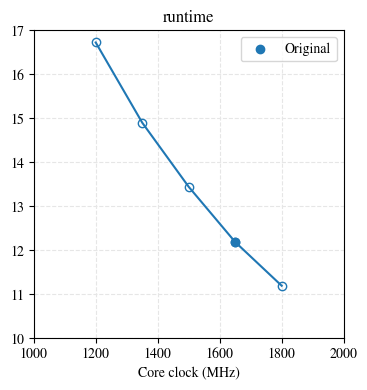

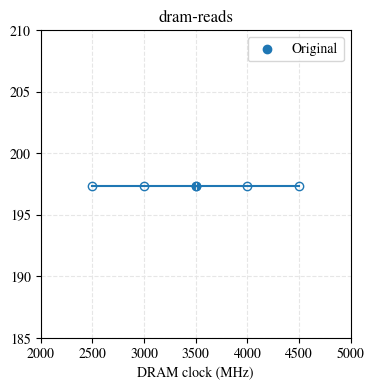

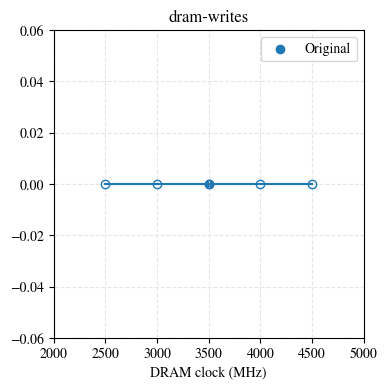

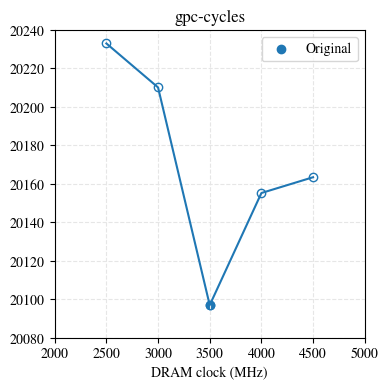

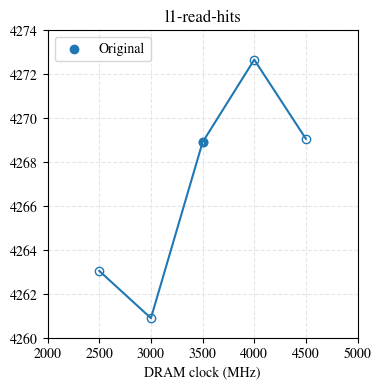

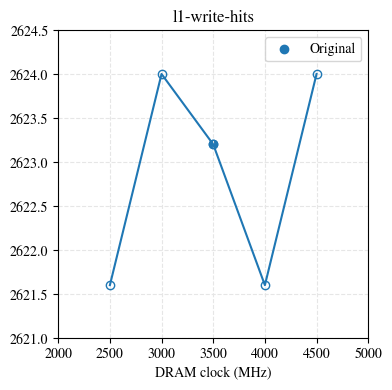

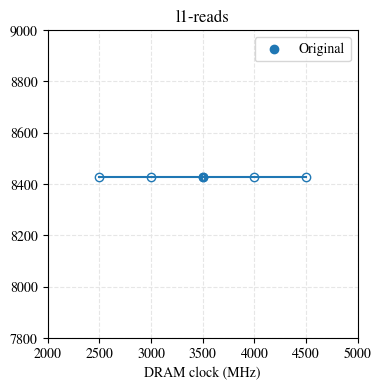

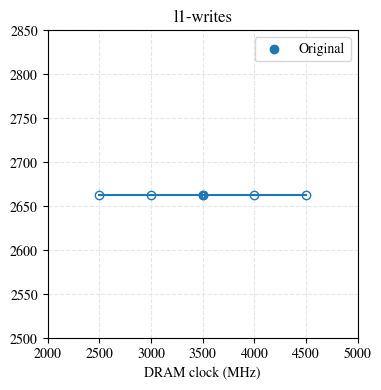

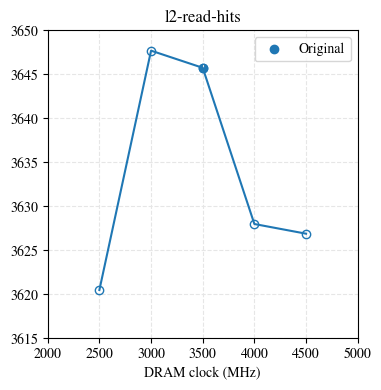

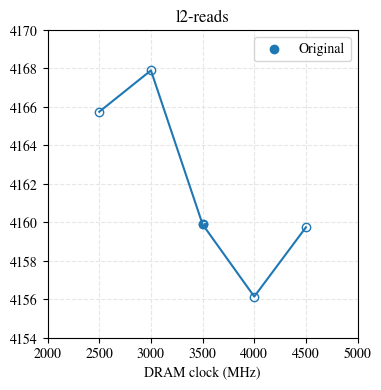

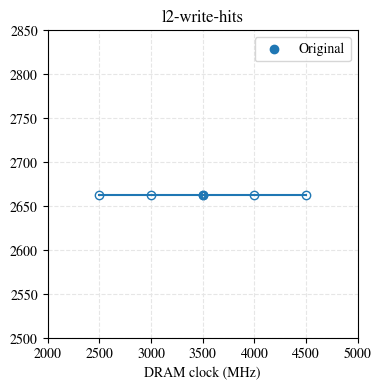

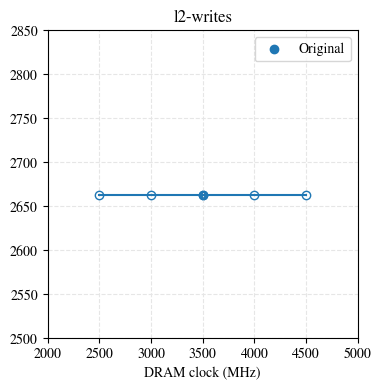

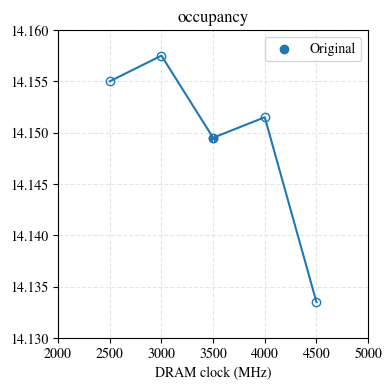

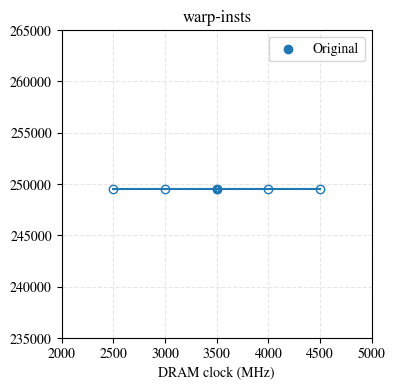

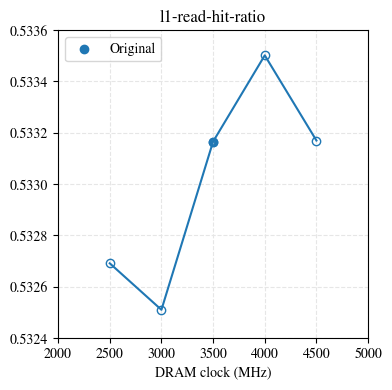

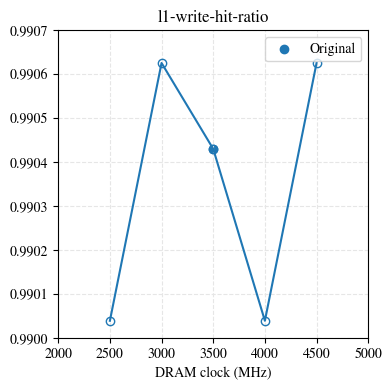

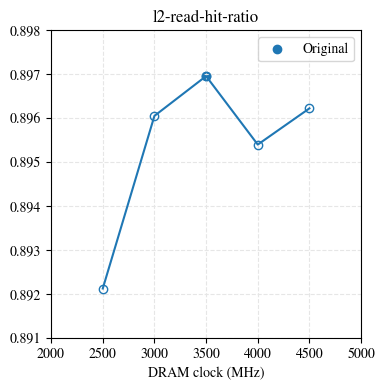

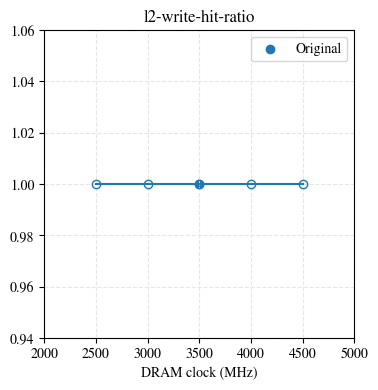

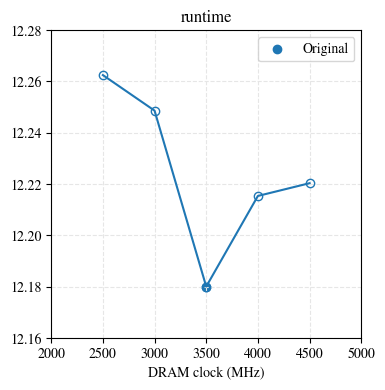

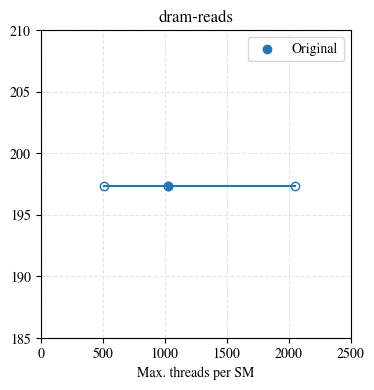

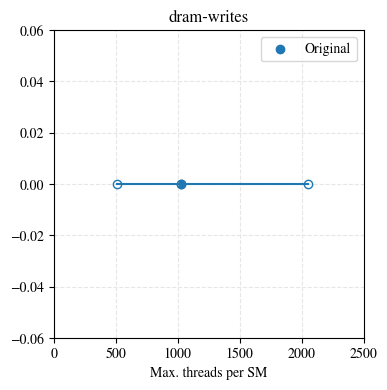

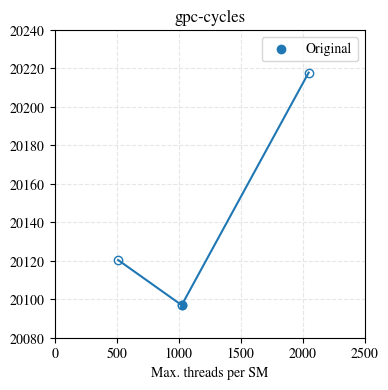

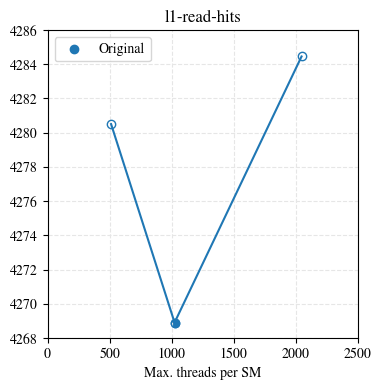

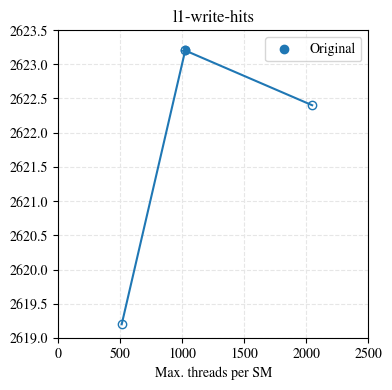

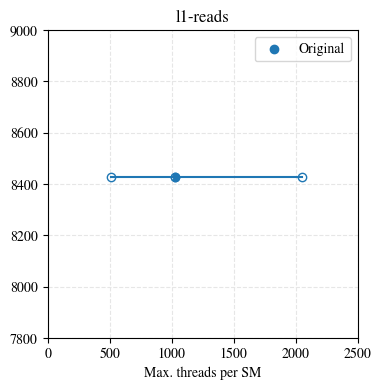

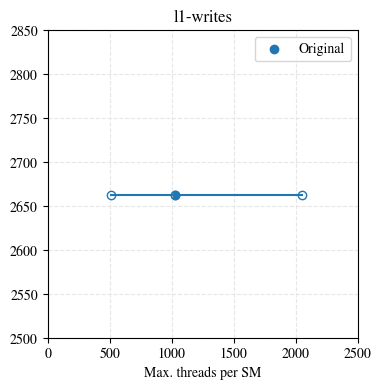

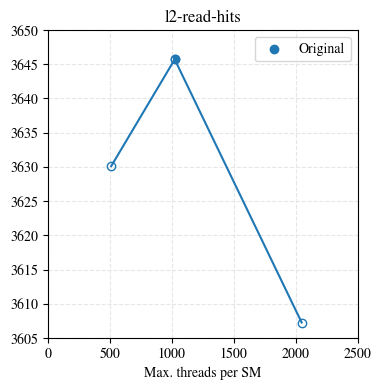

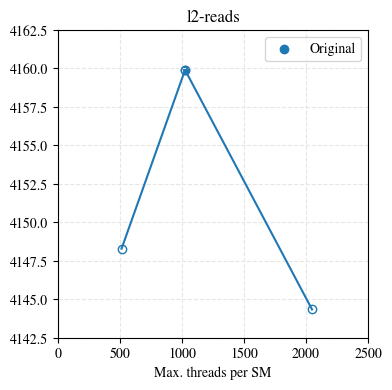

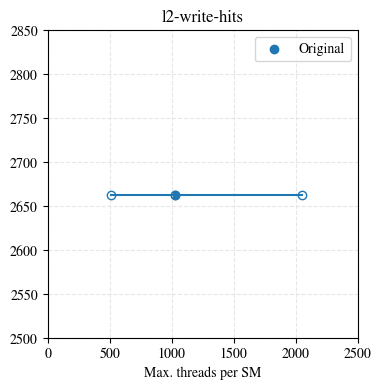

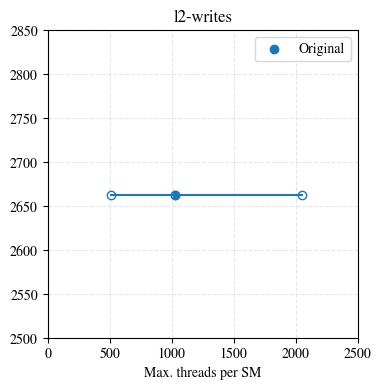

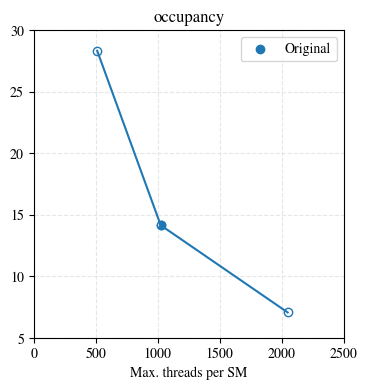

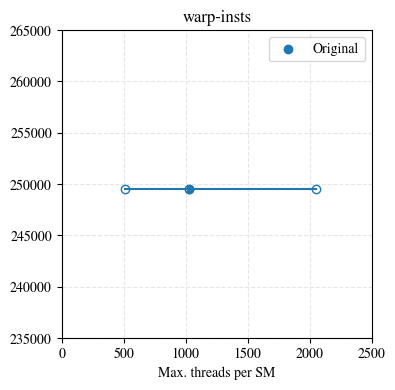

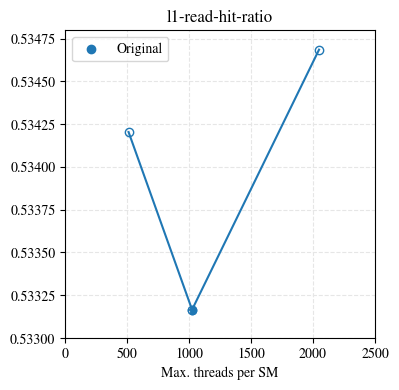

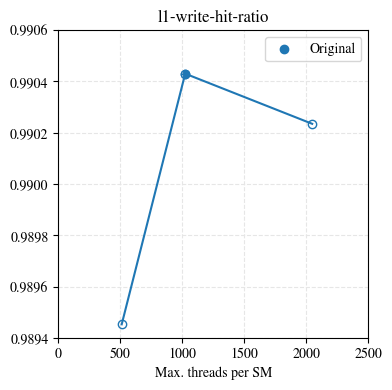

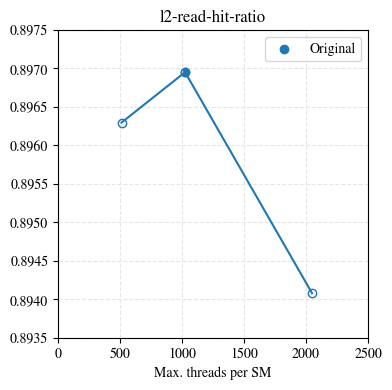

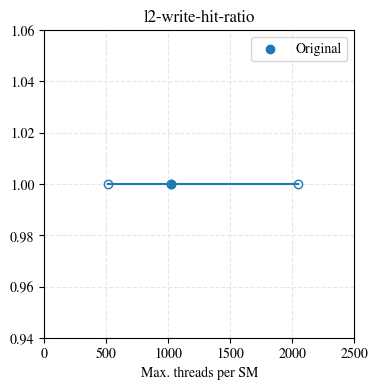

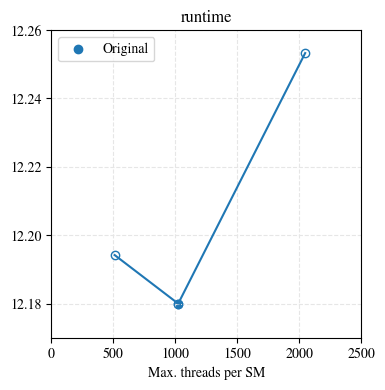

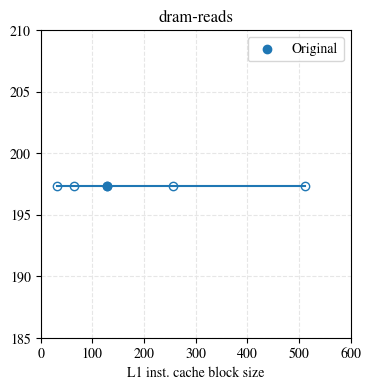

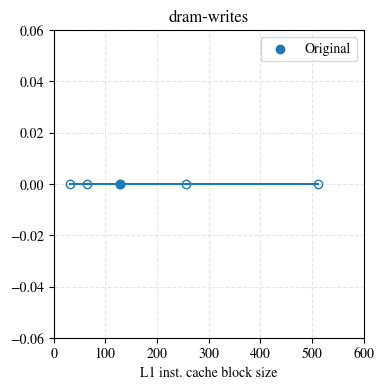

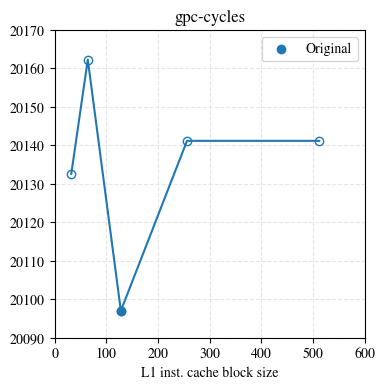

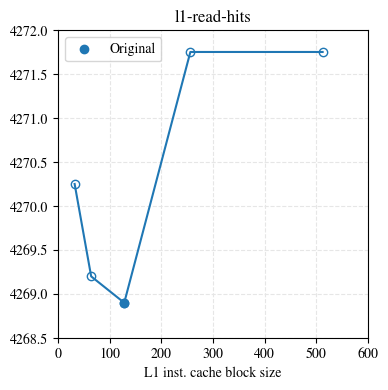

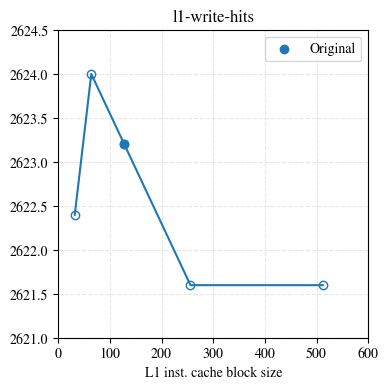

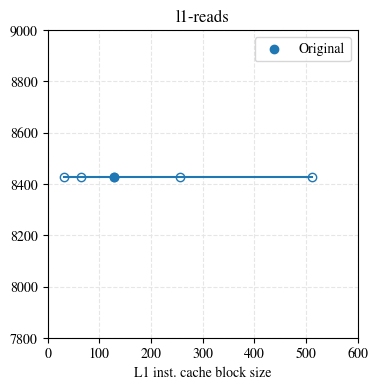

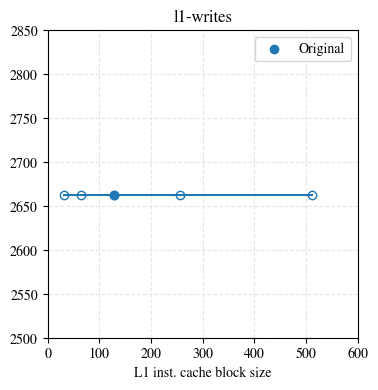

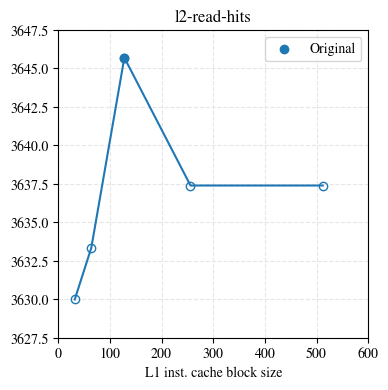

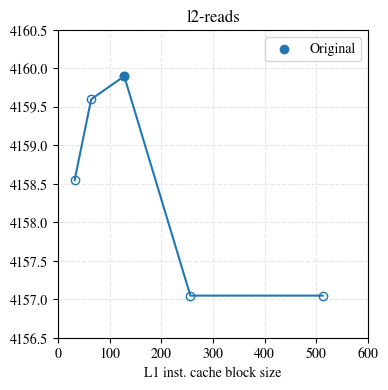

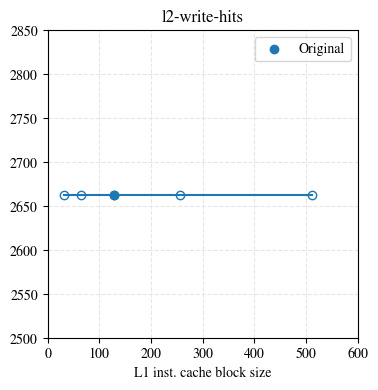

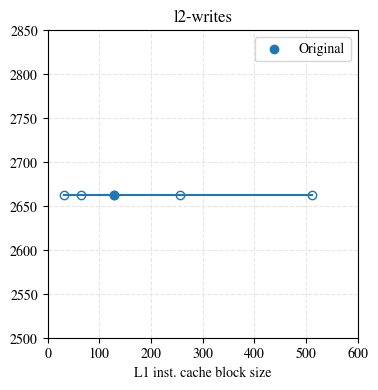

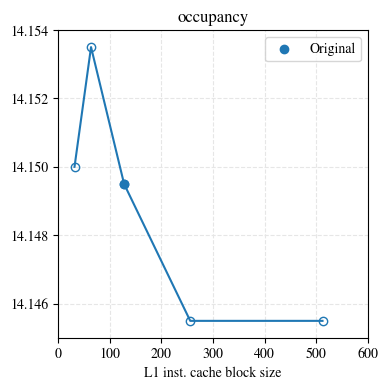

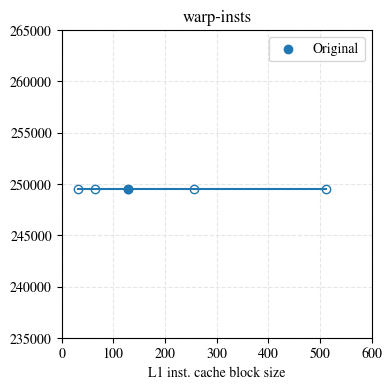

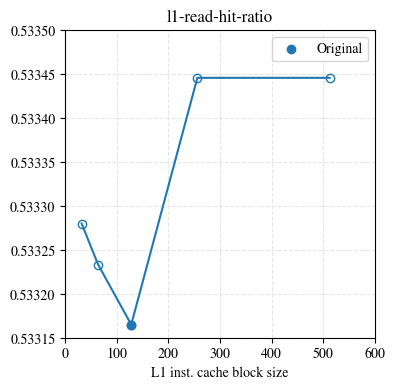

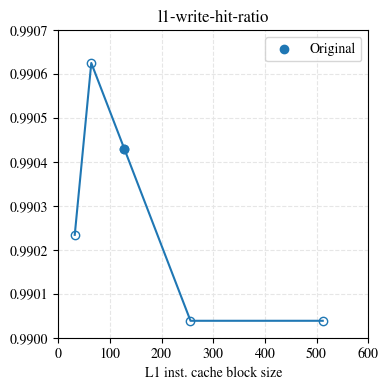

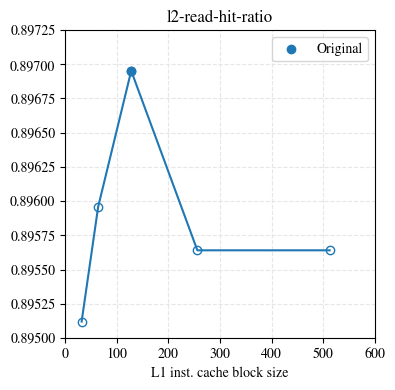

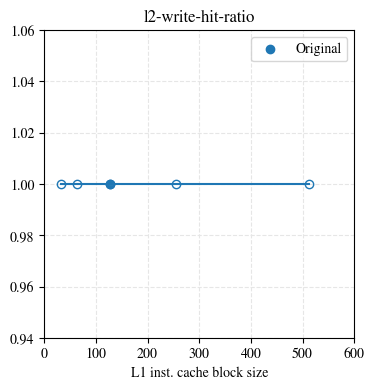

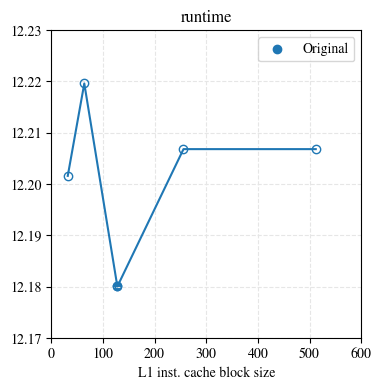

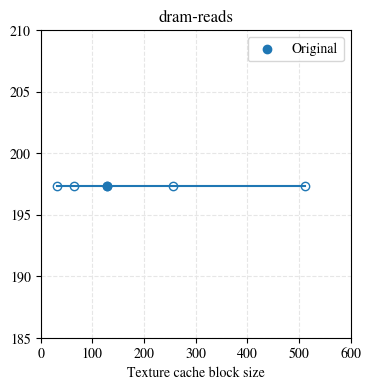

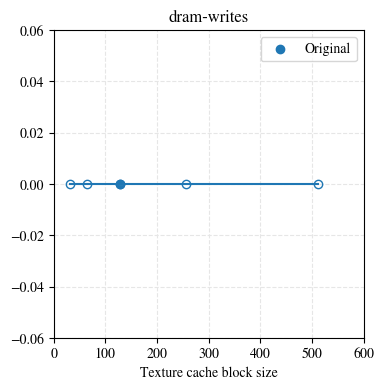

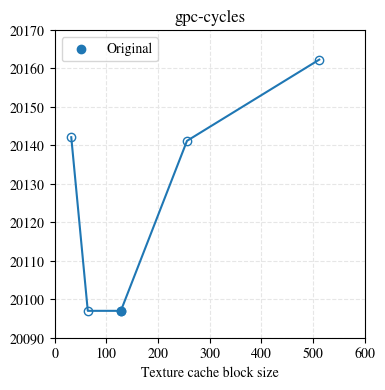

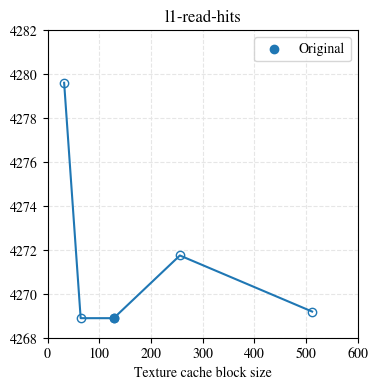

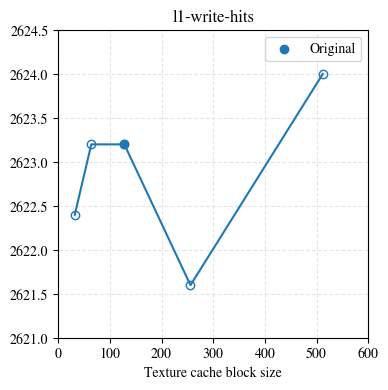

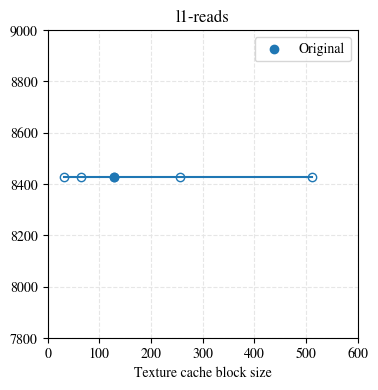

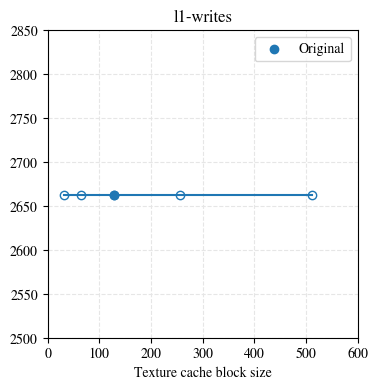

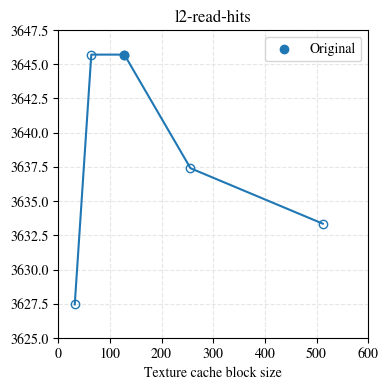

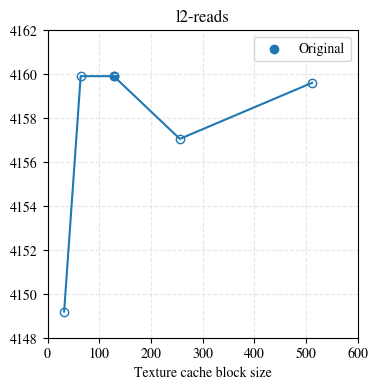

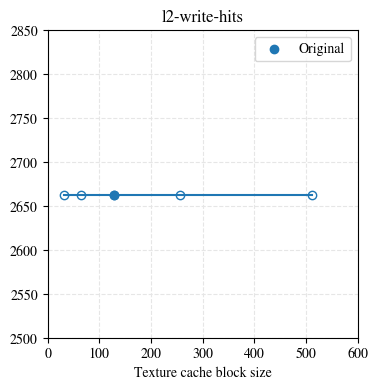

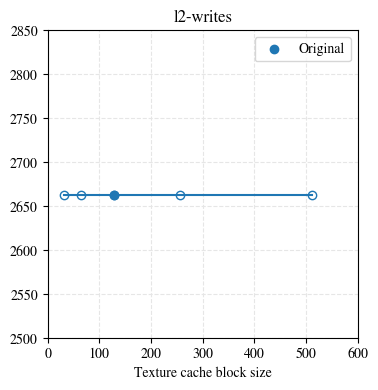

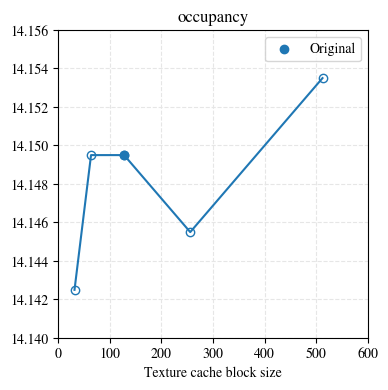

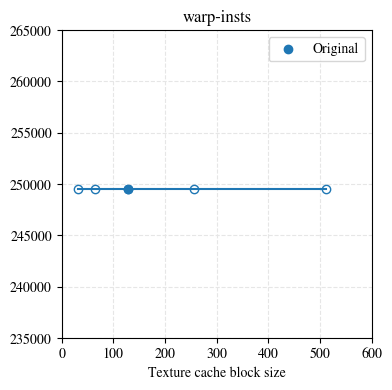

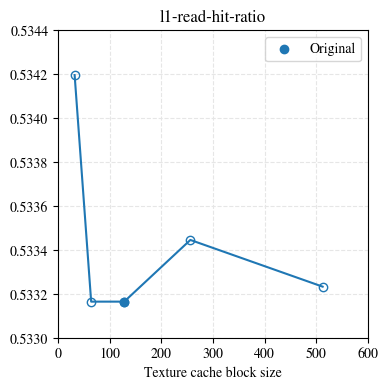

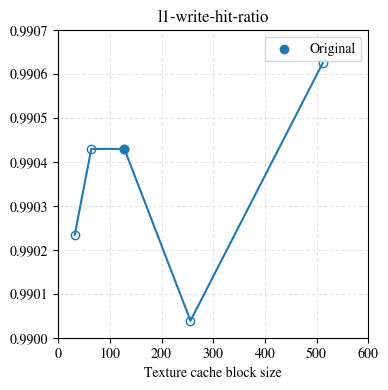

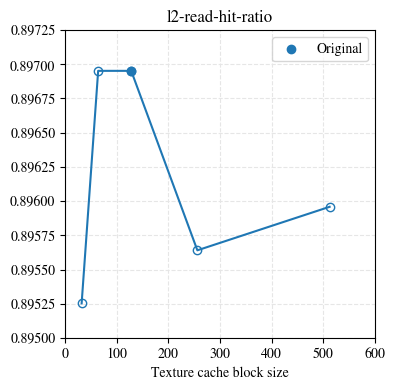

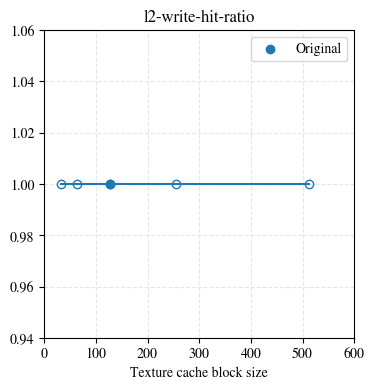

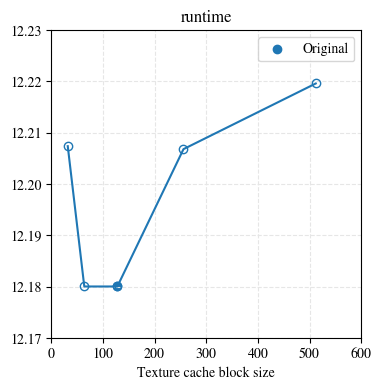

In [ ]:
plot_data = {
    "gpgpu_n_clusters-0-0": [0, "No. of SMs", 48],
    "gpgpu_n_mem-0-0": [0, "No. of mem. controllers", 8],
    "gpgpu_clock_domains-0-0_1_2": [0, "Core clock (MHz)", 1650],
    "gpgpu_clock_domains-0-3": [0, "DRAM clock (MHz)", 3500],
    "gpgpu_shader_core_pipeline-0-0": [0, "Max. threads per SM", 1024],
    "gpgpu_shader_core_pipeline-0-1": [],
    "gpgpu_shader_cta-0-0": [],
    "gpgpu_num_sched_per_core-0-0": [],
    "gpgpu_cache-dl1-0-1_2_3": [],
    "gpgpu_cache-dl2-0-1_2_3": [],
    "gpgpu_cache-il1-0-1_2_3": [1, "L1 inst. cache block size", 128],
    "gpgpu_tex_cache-l1-0-1_2_3": [1, "Texture cache block size", 128],
    "gpgpu_const_cache-l1-0-1_2_3": [],
}

# Loop through data
for key in plot_data.keys():
    if len(plot_data[key]) > 0: # "cache" not in key and 
        for metric in post_names + ["l1-read-hit-ratio", "l1-write-hit-ratio", "l2-read-hit-ratio", "l2-write-hit-ratio", "runtime"]:
            data = dfs[key].iloc[:, [plot_data[key][0]]].join(dfs[key][metric]).drop_duplicates().to_numpy() # dfs[key][[0, metric]].to_numpy()
            
            xlabel = plot_data[key][1]
            ylabel = None
            bounds = find_nearest_n([data[0, 0], data[-1, 0]], 5)
            data[:, 1] /= 20

            plt.close('all')
            plt.figure(figsize=(4, 4))
            plot_sequence(data, bounds, xlabel, ylabel)
            nearest_index = np.argmin(np.abs(data[:, 0] - plot_data[key][2]))
            plt.scatter(data[nearest_index, 0], data[nearest_index, 1], label='Original')
            plt.gca().relim()
            plt.gca().autoscale()
            plt.legend()
            plt.title(metric)
            
            if not os.path.exists(os.path.join(results_path, key)):
                os.makedirs(os.path.join(results_path, key))
            plt.savefig(os.path.join(results_path, key, metric), dpi=300, bbox_inches='tight')
            plt.show()